In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, TheilSenRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from itertools import product
import seaborn as sns




In [3]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# sns.set(rc={'figure.figsize':(10,4)})


In [4]:
c1 = 'tab:blue'
c2 = 'tab:orange'
c3 = 'tab:green'

In [5]:
EXPERIMENT_DESCRIPTORS = ['dataset_type', 'dataset', 'model']

DATASET_ESTIMATORS = [
    'model_type', # SimpleCNN, RESNET, ...
    'data_type', # Spectogram, SensorData, ...
    'n_parameters',
    'datapoint_w', 
    'datapoint_h', 
    'dimensions', 
    'num_classes', 
    'original_data_size'
]

RUN_DESCRIPTORS = [
    'iteration',
    'data_quality_dimension_percentage',
    'loss',
    'categorical_accuracy',
    'categorical_crossentropy',
    'top_3_accuracy',
    'top_5_accuracy',
    'precision',
    'recall',
    'auc',
    'f1_score',
    'effective_epochs',
    'used_data_size',
    'actual_data_percentage_used',
    'emissions_kg',
    'duration',
]


DATASET_TYPE_NAMES = ['images', 'time_series']
DATASET_NAMES = []
MODEL_NAMES = []

MODEL_TYPES = ['SIMPLE_CNN', 'SIMPLE_MLP', 'RESNET', 'Other']
DATA_TYPES = ['Sensor', 'Spectro', 'Image', 'Device', 'Motion', 'EOG', 'Traffic', 'ECG', 'Simulated', 'Other']
METRICS = ['f1_score', 'auc', 'categorical_accuracy', 'precision', 'recall']
REDUCING_METHODS = ['keep_distributions', 'balance_classes']

regressors = {'random_forest': RandomForestRegressor, 'svr': SVR}



In [6]:
cols_to_drop = ['ready', 'loss', 'categorical_crossentropy', 'top_3_accuracy', 'top_5_accuracy', 'project_id', 'duration_per_epoch', 'emissions_per_epoch']
data_location = './../backend/static/experiment_results'

def load_runs(dataset_type):
    """
        Takes all runs from results folders and loads it for analysis
        Return dataframe with runs
    """
    total_df = pd.DataFrame()
    for _, _, files in os.walk(f"{data_location}/{dataset_type}"):
        for file in files:
            if file.endswith('results.csv'):
                total_df = pd.concat([total_df, pd.read_csv(f"{data_location}/{dataset_type}/{file}")]).query("model != 'MLP'")

    return total_df

def process_runs(df):
    """
    Takes the full dataframe of runs on dropping data
    Calculates the regressions for the curve completeness vs metric
    Returns a new dataframe with each experiment (model + dataset) + metric and its curve parameters
    This dataframe contains the training data for the final models (one training dataset inside for each metric) used by the tool. 
    """
    
    unique_experiments = df.groupby(EXPERIMENT_DESCRIPTORS + DATASET_ESTIMATORS, as_index=False).size()
    
    results = []
    
    for experiment in unique_experiments.itertuples():
        experiment_df = df.query(f"model == '{experiment.model}' and dataset == '{experiment.dataset}'")
        regression = LinearRegression()
        X = experiment_df[['data_quality_dimension_percentage']]
        
        for metric in METRICS:
            y = experiment_df[[metric]]

            regression.fit(X, y)
            summary_data = {"metric": metric, "coefficient": regression.coef_[0][0], "intercept": regression.intercept_[0]}

            for attribute in DATASET_ESTIMATORS + EXPERIMENT_DESCRIPTORS:
                summary_data[attribute] = getattr(experiment, attribute)

            results.append(summary_data)


    return pd.DataFrame(results)

def get_experiment_dataset(dataset_df, metric):
    """
    Same procedure as the one done in the web tool
    Takes as input all the training datasets, gets the correct one based on the metric
    Transforms data into sklearn format
    """
    data = dataset_df.query(f"metric == '{metric}'")
    X_cat = []
    X_num = []
    y = []
    for experiment in data.iterrows():
        x_cat = []
        x_num = []
        for estimator in DATASET_ESTIMATORS:
            if estimator in ['model_type', 'data_type']:
                x_cat.append(experiment[1][estimator])
            else:
                x_num.append(experiment[1][estimator])


        metric_coefficient = experiment[1]['coefficient']
        y.append(metric_coefficient)
        X_cat.append(x_cat)
        X_num.append(x_num)

    encoder = OneHotEncoder(handle_unknown='error', categories=[MODEL_TYPES, DATA_TYPES])
    encoder.fit(X_cat)
    X_cat = encoder.transform(X_cat).toarray()

    return np.concatenate([X_cat, X_num], axis=1), np.array(y), encoder

def train_reg(reg_name, data, metric):
    X, y, encoder = get_experiment_dataset(data, metric)
    reg = regressors[reg_name]()
    reg.fit(X, y)
    
    return reg, encoder


def get_samples(df, n):
    df_subset = df.sample(n)
    df = df.drop(df_subset.index)
    
    return df, df_subset


    

## Reduction Curve Example

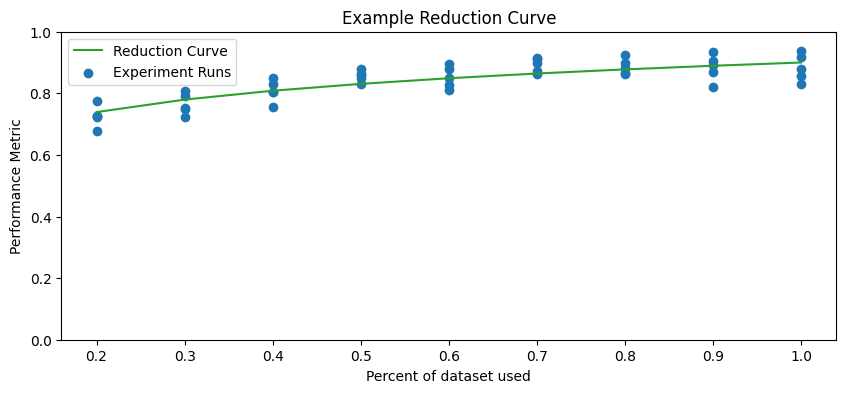

In [7]:
X = np.arange(0.2, 1.1, 0.1)
a = 0.1
b = 0.9
y = a*np.log(X) + b


# plt.plot(X, y, c=c1, label='Reduction Curve')

rep_X = np.repeat(X, 5)
rep_y = np.repeat(y, 5) + np.random.normal(loc=0.0, scale=0.04, size=rep_X.shape)




plt.plot(X, a*np.log(X) + b, c=c3, label='Reduction Curve')



plt.scatter(rep_X, rep_y, label='Experiment Runs', c=c1)
plt.ylim([0, 1])
# plt.xlim([0.15, 1.15])

plt.title("Example Reduction Curve")
plt.ylabel("Performance Metric")
plt.xlabel("Percent of dataset used")
plt.legend()

plt.show()




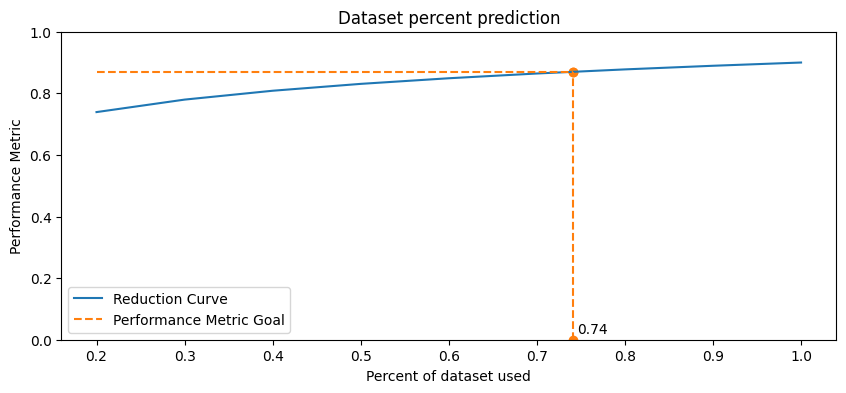

In [8]:
X = np.arange(0.2, 1.1, 0.1)
a = 0.1
b = 0.9
y = a*np.log(X) + b


goal = 0.87

estimated_dataset_percent = np.exp((goal - b)/a)


str_estimated_dataset_percent = str(estimated_dataset_percent)[:4]
X_2 = np.linspace(0.2, estimated_dataset_percent, 5)







plt.plot(X, y, c=c1, label='Reduction Curve')
plt.scatter([estimated_dataset_percent, estimated_dataset_percent], [goal, 0], c=c2)
# ax.annotate
plt.annotate(str_estimated_dataset_percent, (estimated_dataset_percent + 0.005,0.02))
plt.scatter([estimated_dataset_percent], [goal], c=c2)
plt.plot(X_2, np.repeat(goal, X_2.shape), '--',label="Performance Metric Goal", c=c2)
plt.plot(np.repeat(estimated_dataset_percent, 3), np.linspace(0, goal, 3),'--' ,c=c2)

X = np.repeat(X, 5)
y = np.repeat(y, 5) + np.random.normal(loc=0.0, scale=0.04, size=X.shape)
plt.ylim([0, 1])
plt.title("Dataset percent prediction")
plt.ylabel("Performance Metric")
plt.xlabel("Percent of dataset used")
plt.legend()

plt.show()



## Gathered data showcase

In [9]:
time_series_runs_df = load_runs('time_series')
time_series_experiment_curves_df = process_runs(time_series_runs_df)

In [10]:
column_names_mapping = {
    'model': 'Model',
    'dataset': 'Dataset',
#     'dataset_type': 'Dataset type',
    'data_type': 'Dataset type',
    'num_classes': 'Number of classes',
    'original_data_size': 'Number of training samples',
    'datapoint_w': 'Length of sequence',
    'dimensions': 'Number of dimensions',
    'model_type': 'Model type',
    'n_parameters': 'Number of parameters',
    'data_quality_dimension_percentage': 'Dataset subset percentage',
    'iteration': 'Iteration',
    'categorical_accuracy': "Categorical accuracy",
    'precision': 'Precision',
    'recall': 'Recall',
    'auc': 'AUC',
    'f1_score': 'F1 score'
}
time_series_runs_df.rename(columns=column_names_mapping, inplace=True)

time_series_runs_df.columns

Index(['Model', 'Dataset', 'dataset_type', 'experiment', 'Iteration',
       'experiment_method', 'data_quality_dimension',
       'Dataset subset percentage', 'loss', 'Categorical accuracy',
       'categorical_crossentropy', 'top_3_accuracy', 'top_5_accuracy',
       'Precision', 'Recall', 'AUC', 'F1 score', 'effective_epochs',
       'used_data_size', 'actual_data_percentage_used',
       'Number of training samples', 'Dataset type', 'Number of classes',
       'Model type', 'Length of sequence', 'datapoint_h',
       'Number of dimensions', 'emissions_kg', 'duration',
       'Number of parameters', 'project_id', 'ready'],
      dtype='object')

In [11]:
dataset = 'StarLightCurves'
model = 'RESNET'
a = time_series_runs_df.query(
    f"Dataset=='{dataset}' and Model=='{model}'"
)[column_names_mapping.values()]

a.head(1).to_dict('records')

[{'Model': 'RESNET',
  'Dataset': 'StarLightCurves',
  'Dataset type': 'Sensor',
  'Number of classes': 3,
  'Number of training samples': 1000,
  'Length of sequence': 1024,
  'Number of dimensions': 1,
  'Model type': 'RESNET',
  'Number of parameters': 506947,
  'Dataset subset percentage': 1.0,
  'Iteration': 0,
  'Categorical accuracy': 0.976930558681488,
  'Precision': 0.9770240783691406,
  'Recall': 0.975837767124176,
  'AUC': 0.9941040873527528,
  'F1 score': 0.976930558681488}]

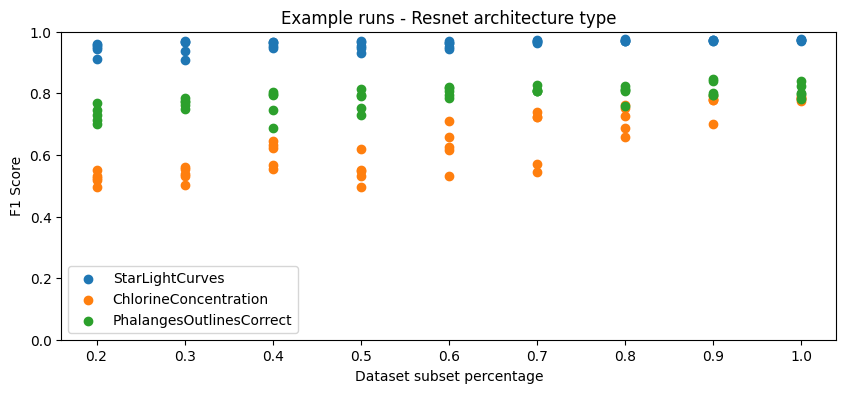

In [12]:
d1 = 'StarLightCurves'
d2 = 'ChlorineConcentration'
d3 = 'PhalangesOutlinesCorrect'
a = time_series_runs_df.query(
    f"Dataset == '{d1}' and Model=='{model}'"
)[column_names_mapping.values()]
b = time_series_runs_df.query(
    f"Dataset == '{d2}' and Model=='{model}'"
)[column_names_mapping.values()]
c = time_series_runs_df.query(
    f"Dataset == '{d3}' and Model=='{model}'"
)[column_names_mapping.values()]



plt.scatter(a['Dataset subset percentage'], a['F1 score'], c=c1, label=d1)
plt.scatter(b['Dataset subset percentage'], b['F1 score'], c=c2, label=d2)
plt.scatter(c['Dataset subset percentage'], c['F1 score'], c=c3, label=d3)

plt.title("Example runs - Resnet architecture type")
plt.ylim([0, 1])
plt.ylabel("F1 Score")
plt.xlabel("Dataset subset percentage")
plt.legend()

plt.show()





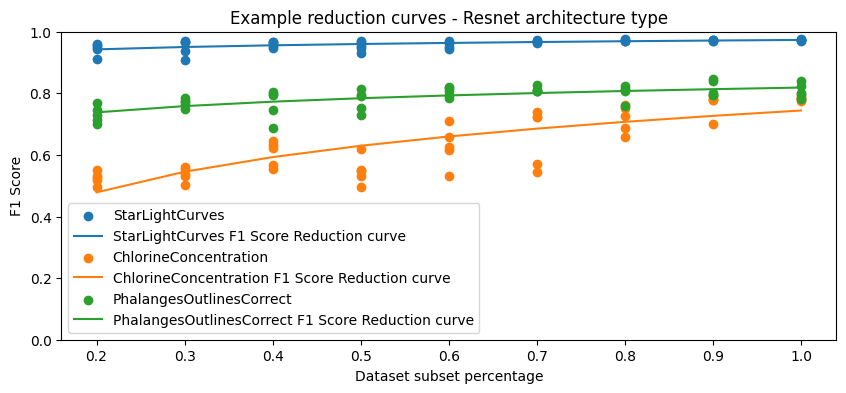

In [28]:
d1 = 'StarLightCurves'
d2 = 'ChlorineConcentration'
d3 = 'PhalangesOutlinesCorrect'
a = time_series_runs_df.query(
    f"Dataset == '{d1}' and Model=='{model}'"
)[column_names_mapping.values()]
b = time_series_runs_df.query(
    f"Dataset == '{d2}' and Model=='{model}'"
)[column_names_mapping.values()]
c = time_series_runs_df.query(
    f"Dataset == '{d3}' and Model=='{model}'"
)[column_names_mapping.values()]

r1 = LinearRegression().fit(np.expand_dims(np.log(a['Dataset subset percentage']), 1), a['F1 score'])
r2 = LinearRegression().fit(np.expand_dims(np.log(b['Dataset subset percentage']), 1), b['F1 score'])
r3 = LinearRegression().fit(np.expand_dims(np.log(c['Dataset subset percentage']), 1), c['F1 score'])


plt.scatter(a['Dataset subset percentage'], a['F1 score'], c=c1, label=d1)
a_X = np.unique(a['Dataset subset percentage'])
plt.plot(a_X, np.log(a_X)*r1.coef_[0] + r1.intercept_, label=f"{d1} F1 Score Reduction curve")


b_X = np.unique(b['Dataset subset percentage'])
plt.scatter(b['Dataset subset percentage'], b['F1 score'], c=c2, label=d2)
plt.plot(b_X, np.log(b_X)*r2.coef_[0] + r2.intercept_, label=f"{d2} F1 Score Reduction curve")

c_X = np.unique(c['Dataset subset percentage'])
plt.scatter(c['Dataset subset percentage'], c['F1 score'], c=c3, label=d3)
plt.plot(c_X, np.log(c_X)*r3.coef_[0] + r3.intercept_, label=f"{d3} F1 Score Reduction curve")

plt.title("Example reduction curves - Resnet architecture type")
plt.ylim([0, 1])
plt.ylabel("F1 Score")
plt.xlabel("Dataset subset percentage")
plt.legend()

plt.show()

